In [344]:
from bs4 import BeautifulSoup as bs
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import time
import requests
import random
import aiohttp
import seaborn as sns
import re

In [345]:
async def getJSONData(full_url):
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(full_url) as r:
                if r.status == 200:
                    js = await r.json()
                    return js
    except:
        return None


In [346]:
def getTrackData(player_id):
    url = 'https://mkwlounge.gg/ladder/player.php?player_id={}&ladder_id=3'.format(player_id)
    # print(url)
    playerpage = requests.get(url, timeout=3)
    playersoup = bs(playerpage.content)
    playertables = playersoup.find_all('table')
    dfs = pd.read_html(str(playertables))[3]
    return dfs

In [347]:
def formatTrackData(df, index):
    df.drop(['Std Dev Time', 'Average Points', 'Fastest Time', 'Slowest Time'], axis=1, inplace=True)
    melted = df.pivot(index = 'Engine', columns='Track')
    melted = melted.drop('Mirror', axis=0, errors='ignore')
    melted = melted.drop('100cc', axis=0, errors='ignore')
    melted = melted.rename(index={'150cc': index})
    return melted

In [348]:
upperDict = {'Average Placement':'AP',
             'Average Time': 'AT',
             'Races': 'R',
             'player_id':'player_id'}
def renameCols(df):
    df.rename(columns=lambda x: upperDict[x], level=0, inplace=True)
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df.drop(['AT -','AP -', 'R -'], axis=1, inplace=True)
    df.rename(columns=lambda c: c.replace(' (Nintendo)',''), inplace=True)
    df.index.name = None
    return df

In [349]:
async def getPlayerData():
    metadata = await getJSONData('https://www.mkwlounge.gg/api/ladderplayer.php?ladder_type=rt&all=1')
    playerdata = pd.DataFrame(metadata['results'])
    playerdata = playerdata[['player_id','player_name','current_mmr','current_lr','current_class','win_percentage','win10_percentage','average_score','average10_score','total_events']]
    playerdata = playerdata.loc[playerdata["total_events"]!= 0]
    playerdata = playerdata.loc[playerdata["current_mmr"] >= 0]
    return playerdata

In [350]:
def getTime(time):
    min, sec = time.split(':')
    t = (int(min) * 60) + float(sec) 
    
    return t

In [351]:
def typeColumns(combodata):
    APcols = combodata.columns[10:42]
    ATcols = combodata.columns[42:74]
    Rcols = combodata.columns[74:106]
    for r in Rcols:
        combodata[r] = combodata[r].replace(np.nan, 0)
        combodata[r] = combodata[r].astype(int)
    for p in APcols:
        combodata[p] = combodata[p].replace(np.nan, '13th')
        combodata[p] = combodata[p].apply(lambda x: re.sub("[^0-9]", "", x)) 
        combodata[p] = combodata[p].astype(int)
    for T in ATcols:
        combodata[T] = combodata[T].apply(lambda x: getTime(x) if x != np.nan else x)
        combodata[T] = combodata[T].astype(float)
    avg = pd.DataFrame(combodata[ATcols])
    avg['current_class'] = combodata['current_class']
    groups = avg.groupby('current_class')
    means = groups.mean()
    # means.loc['Class A'][ATcols[0]]
    for T in ATcols:
        for i,c,m in combodata[['current_class',T]].itertuples():
            if np.isnan(m):
                combodata.at[i,T] = means.loc[c][T]

    
    return combodata

In [352]:
playerdata = await getPlayerData()
playerdata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92


In [353]:


dfs = []
i =0
for index, row in playerdata.iterrows():
    trackdata = getTrackData(row['player_id'])
    formatData = formatTrackData(trackdata, index)
    formatData['player_id'] = row['player_id']
    dfs.append(formatData)
    # if i %100 == 0:
    #     print('working: ' + str(i))
    # i = i + 1

trackdata = pd.DataFrame().append(dfs)
trackdata = renameCols(trackdata)
trackdata.head()

/Users/fordjackson/opt/anaconda3/envs/appML/lib/python3.9/site-packages/bs4/__init__.py:611: RuntimeWarning: coroutine 'getJSONData' was never awaited
  o.setup(parent, previous_element, next_element, previous_sibling, next_sibling)


,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine,player_id
0,5th,5th,5th,4th,5th,3rd,5th,4th,5th,5th,...,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0,260
1,6th,5th,6th,4th,5th,8th,6th,5th,6th,5th,...,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0,290
2,6th,5th,5th,5th,5th,5th,5th,6th,6th,6th,...,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0,1207
3,5th,5th,5th,5th,5th,5th,5th,7th,5th,5th,...,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0,1614
4,6th,5th,5th,6th,5th,3rd,4th,6th,6th,5th,...,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0,1043


In [621]:
combodata = pd.merge(playerdata,trackdata, left_on='player_id', right_on='player_id')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55,...,61.0,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99,...,97.0,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97,...,76.0,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


In [622]:
combodata.to_csv('datasets/loungedata.csv', index=False)

## If data has already been sourced

In [152]:
combodata = pd.read_csv('datasets/loungedata.csv')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17155,15757,Class X,0.962963,1.000000,99.0370,96.1000,54,...,61,46,59,24,17,97,128,16,39,14
1,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.7500,127,...,161,146,121,61,24,217,304,36,79,54
2,290,barney,14495,14979,Class X,0.784946,0.600000,91.0257,90.7000,94,...,94,61,67,22,21,87,122,18,42,34
3,1614,Kasperinos,13902,14817,Class X,0.758242,0.400000,90.2771,76.9286,92,...,73,55,43,26,19,102,104,7,36,22
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.9000,92,...,70,58,54,20,15,62,104,13,31,22


In [355]:
combodata['current_class'] = combodata['current_class'].astype('category')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55,...,61.0,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99,...,97.0,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97,...,76.0,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


## Data plotting and EDA

In [136]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='current_mmr', ylabel='Count'>

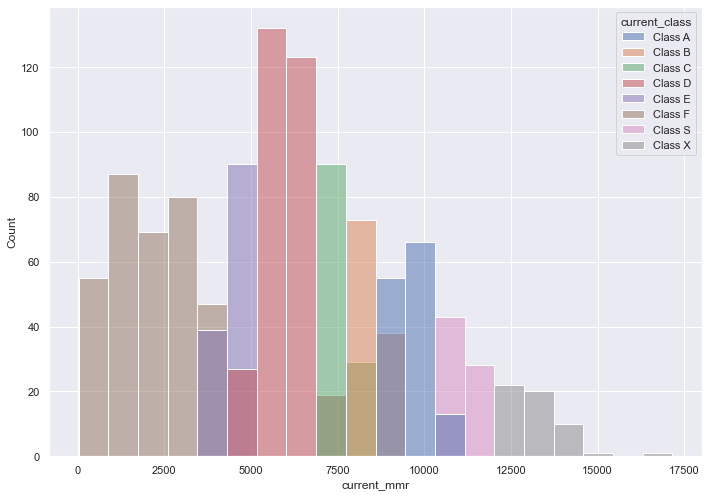

In [137]:
sns.histplot(data = combodata, x='current_mmr', hue = 'current_class', bins=20)

In [138]:
combodata[APcols].describe()

,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,AP Wii Koopa Cape,AP Wii Luigi Circuit,AP Wii Maple Treeway,AP Wii Mario Circuit,AP Wii Moo Moo Meadows,AP Wii Moonview Highway,AP Wii Mushroom Gorge,AP Wii Rainbow Road,AP Wii Toad's Factory,AP Wii Wario's Gold Mine
count,1185,855,1143,974,1204,870,1129,955,1001,1132,...,1130,1095,1131,971,1030,1157,1199,1043,1179,1041
unique,12,12,12,12,11,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
top,6th,6th,6th,6th,6th,6th,6th,6th,6th,6th,...,6th,7th,6th,6th,6th,6th,6th,6th,6th,6th
freq,449,173,415,249,458,195,333,224,298,380,...,382,329,343,247,260,370,438,250,433,292


In [139]:
combodata.loc[combodata['player_id'] == 4088]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
423,4088,fordj262,4226,4116,Class E,0.75,0.75,85.0,85.0,4,...,1.0,1.0,1.0,NaN,1.0,NaN,2.0,1.0,2.0,NaN


In [623]:
combodata.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 0 to 1273
Data columns (total 106 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    player_id                   1274 non-null   int64  
 1    player_name                 1274 non-null   object 
 2    current_mmr                 1274 non-null   int64  
 3    current_lr                  1274 non-null   int64  
 4    current_class               1274 non-null   object 
 5    win_percentage              1274 non-null   float64
 6    win10_percentage            1274 non-null   float64
 7    average_score               1274 non-null   float64
 8    average10_score             1274 non-null   float64
 9    total_events                1274 non-null   int64  
 10   AP DS Delfino Square        1197 non-null   object 
 11   AP DS Desert Hills          863 non-null    object 
 12   AP DS Peach Gardens         1155 non-null   object 
 13   AP DS Yoshi Fall

In [141]:
print(combodata[ATcols[0]].iloc[0])

2:24.794


In [142]:
combodata[ATcols].describe()

,AT DS Delfino Square,AT DS Desert Hills,AT DS Peach Gardens,AT DS Yoshi Falls,AT GBA Bowser Castle 3,AT GBA Shy Guy Beach,AT GCN DK Mountain,AT GCN Mario Circuit,AT GCN Peach Beach,AT GCN Waluigi Stadium,...,AT Wii Koopa Cape,AT Wii Luigi Circuit,AT Wii Maple Treeway,AT Wii Mario Circuit,AT Wii Moo Moo Meadows,AT Wii Moonview Highway,AT Wii Mushroom Gorge,AT Wii Rainbow Road,AT Wii Toad's Factory,AT Wii Wario's Gold Mine
count,1185,855,1143,974,1204,870,1129,955,1001,1132,...,1130,1095,1131,971,1030,1157,1199,1043,1179,1041
unique,1110,817,1057,900,1145,829,1077,898,928,1069,...,1066,1011,1086,911,952,1093,1111,1002,1106,996
top,2:27.107,1:53.077,2:23.018,1:14.715,2:40.041,1:42.329,2:31.040,1:54.805,1:28.743,2:14.177,...,2:42.595,1:25.267,2:39.985,1:36.677,1:33.595,2:04.416,2:04.497,2:53.436,2:12.676,2:10.641
freq,3,2,4,3,3,2,3,3,3,2,...,3,4,3,2,3,3,3,3,3,3


## Filling Na valuse

In [487]:
APcols = combodata.columns[10:42]
ATcols = combodata.columns[42:74]
Rcols = combodata.columns[74:106]

In [488]:
for r in Rcols:
    combodata[r] = combodata[r].replace(np.nan, 0)
    combodata[r] = combodata[r].astype(int)

In [489]:
for p in APcols:
    combodata[p] = combodata[p].replace(np.nan, '13th')
    combodata[p] = combodata[p].apply(lambda x: re.sub("[^0-9]", "", x)) 
    combodata[p] = combodata[p].astype(int)

In [490]:
for T in ATcols:
    combodata[T] = combodata[T].apply(lambda x: getTime(x) if x != np.nan else x)
    combodata[T] = combodata[T].astype(float)

In [569]:
for T in ATcols:
    for i,c,m in combodata[['current_class',T]].itertuples():
        if np.isnan(m):
            combodata.at[i,T] = means.loc[c][T]

            

In [510]:
print(ATcols)

Index(['AT DS Delfino Square', 'AT DS Desert Hills', 'AT DS Peach Gardens',
       'AT DS Yoshi Falls', 'AT GBA Bowser Castle 3', 'AT GBA Shy Guy Beach',
       'AT GCN DK Mountain', 'AT GCN Mario Circuit', 'AT GCN Peach Beach',
       'AT GCN Waluigi Stadium', 'AT N64 Bowser's Castle',
       'AT N64 DK's Jungle Parkway', 'AT N64 Mario Raceway',
       'AT N64 Sherbet Land', 'AT SNES Ghost Valley 2',
       'AT SNES Mario Circuit 3', 'AT Wii Bowser's Castle',
       'AT Wii Coconut Mall', 'AT Wii DK Summit', 'AT Wii Daisy Circuit',
       'AT Wii Dry Dry Ruins', 'AT Wii Grumble Volcano', 'AT Wii Koopa Cape',
       'AT Wii Luigi Circuit', 'AT Wii Maple Treeway', 'AT Wii Mario Circuit',
       'AT Wii Moo Moo Meadows', 'AT Wii Moonview Highway',
       'AT Wii Mushroom Gorge', 'AT Wii Rainbow Road', 'AT Wii Toad's Factory',
       'AT Wii Wario's Gold Mine'],
      dtype='object')


In [552]:
avg = pd.DataFrame(combodata[ATcols])
avg['current_class'] = combodata['current_class']
groups = avg.groupby('current_class')
means = groups.mean()
means.loc['Class A'][ATcols[0]]



146.36665

<AxesSubplot:xlabel='AP DS Delfino Square', ylabel='Count'>

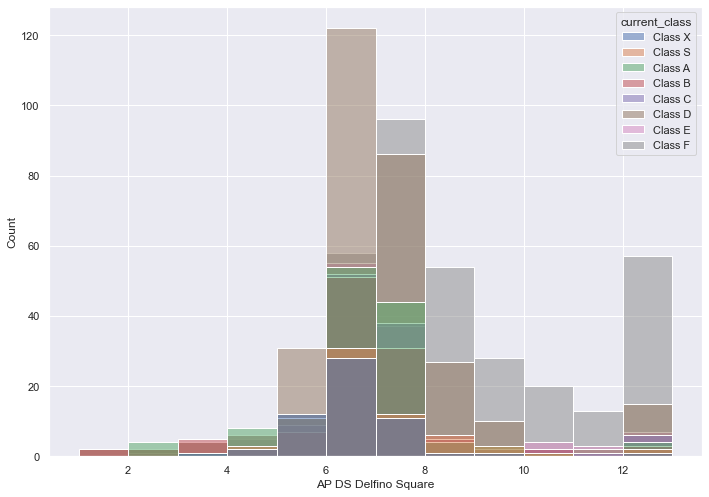

In [527]:
sns.histplot(data = combodata, x=APcols[0], hue='current_class', bins=12)

    

In [57]:
re.sub("[^0-9]", "", "1st")

'1'

In [570]:
combodata[ATcols].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 0 to 1273
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AT DS Delfino Square        1274 non-null   float32
 1   AT DS Desert Hills          1274 non-null   float32
 2   AT DS Peach Gardens         1274 non-null   float32
 3   AT DS Yoshi Falls           1274 non-null   float32
 4   AT GBA Bowser Castle 3      1274 non-null   float32
 5   AT GBA Shy Guy Beach        1274 non-null   float32
 6   AT GCN DK Mountain          1274 non-null   float32
 7   AT GCN Mario Circuit        1274 non-null   float32
 8   AT GCN Peach Beach          1274 non-null   float32
 9   AT GCN Waluigi Stadium      1274 non-null   float32
 10  AT N64 Bowser's Castle      1274 non-null   float32
 11  AT N64 DK's Jungle Parkway  1274 non-null   float32
 12  AT N64 Mario Raceway        1274 non-null   float32
 13  AT N64 Sherbet Land         1274 

In [620]:
combodata.to_csv('datasets/loungedata-formated.csv', index=False)

In [122]:
print(type(np.inf))

<class 'float'>


In [572]:
# combodata = pd.read_csv('datasets/loungedata.csv')
combodata.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 0 to 1273
Data columns (total 106 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    player_id                   1274 non-null   int64  
 1    player_name                 1274 non-null   object 
 2    current_mmr                 1274 non-null   int64  
 3    current_lr                  1274 non-null   int64  
 4    current_class               1274 non-null   object 
 5    win_percentage              1274 non-null   float32
 6    win10_percentage            1274 non-null   float32
 7    average_score               1274 non-null   float32
 8    average10_score             1274 non-null   float32
 9    total_events                1274 non-null   int64  
 10   AP DS Delfino Square        1274 non-null   int64  
 11   AP DS Desert Hills          1274 non-null   int64  
 12   AP DS Peach Gardens         1274 non-null   int64  
 13   AP DS Yoshi Fall

In [533]:
# Select columns with 'float64' dtype  
float64_cols = list(combodata.select_dtypes(include='float64'))

# The same code again calling the columns
combodata[float64_cols] = combodata[float64_cols].astype('float32')

In [534]:
cols = ATcols.to_list() + APcols.to_list() + Rcols.to_list()
len(cols)

96

## Train the data

In [573]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

forest_class = RandomForestClassifier(max_depth=10, random_state=42)

In [574]:
train, test = train_test_split(combodata, test_size=0.30)
train[:5]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
1105,1565,July,5022,444,Class D,0.000000,0.000000,36.000000,36.000000,1,...,3,5,4,2,0,5,6,2,4,1
190,4155,Danny G,6828,6696,Class D,0.565217,0.400000,76.434799,71.400002,23,...,15,3,7,0,2,11,17,2,13,7
40,1582,KA,11762,10860,Class S,0.765625,0.700000,76.218803,71.599998,64,...,35,27,26,6,7,40,53,5,23,11
66,1608,Kapera,10152,9370,Class A,0.652174,0.800000,76.457100,81.699997,70,...,65,34,33,14,15,63,76,21,35,18
806,2973,Smoke,5299,1698,Class D,0.461538,0.333333,57.076900,52.222198,14,...,7,7,6,1,2,7,13,5,7,4


In [588]:
data = train[cols]
# data  = data.drop(Rcols, axis=1)
labels = train['current_lr']
data[:5]

,AT DS Delfino Square,AT DS Desert Hills,AT DS Peach Gardens,AT DS Yoshi Falls,AT GBA Bowser Castle 3,AT GBA Shy Guy Beach,AT GCN DK Mountain,AT GCN Mario Circuit,AT GCN Peach Beach,AT GCN Waluigi Stadium,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
1105,147.600998,116.930954,150.598999,74.811996,170.378006,102.624107,156.082001,112.277214,85.163002,135.710007,...,3,5,4,2,0,5,6,2,4,1
190,147.755997,116.930954,145.110992,73.328003,164.973007,100.388000,149.132004,109.447998,86.827003,135.832993,...,15,3,7,0,2,11,17,2,13,7
40,146.057007,115.420998,142.667999,69.551003,159.873993,100.219002,148.074005,112.375000,87.539001,132.867004,...,35,27,26,6,7,40,53,5,23,11
66,145.834000,115.632004,142.921005,71.515999,162.106995,100.195999,149.268997,113.277000,87.620003,133.210007,...,65,34,33,14,15,63,76,21,35,18
806,148.160995,123.261002,144.565994,69.658997,165.056000,101.210999,151.957001,117.920998,90.675003,136.863007,...,7,7,6,1,2,7,13,5,7,4


In [589]:
labels[:5]

1105      444
190      6696
40      10860
66       9370
806      1698
Name: current_lr, dtype: int64

In [263]:
forest_class.fit(data, labels)

RandomForestClassifier(max_depth=10, random_state=42)

In [264]:
from sklearn.metrics import mean_squared_error
predictions = forest_class.predict(test[data.columns])
forest_mse = mean_squared_error(test['current_mmr'], predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2854.4699885169425

In [265]:
p = forest_class.predict(combodata[data.columns].iloc[423:424])
print(p)

[4226]


In [217]:
combodata.loc[combodata['player_name'] == 'fordj262' ]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
423,4088,fordj262,4226,4116,Class E,0.75,0.75,85.0,85.0,4,...,1,1,1,0,1,0,2,1,2,0


### Random forest Classifier

In [275]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [100], 'max_features': [10, 20, 30, 40, 50]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(data, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [10, 20, 30, 40, 50],
                          'n_estimators': [100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [462]:
estimator = grid_search.best_estimator_
final_predictions = estimator.predict(test[data.columns])

final_mse = mean_squared_error(test['current_mmr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

/Users/fordjackson/opt/anaconda3/envs/appML/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- R DS Delfino Square
- R DS Desert Hills
- R DS Peach Gardens
- R DS Yoshi Falls
- R GBA Bowser Castle 3
- ...
Feature names seen at fit time, yet now missing:
- average10_score
- average_score
- total_events
- win10_percentage
- win_percentage

  warnings.warn(message, FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [230]:
p = estimator.predict(combodata[data.columns].iloc[0:1])
print(p)

[16247.16666667]


In [233]:
combodata.iloc[0]['current_mmr']

17155

In [278]:
print(grid_search.best_params_)

{'max_features': 20, 'n_estimators': 100}


In [295]:
print(errors)

[1129.6729097408597, 1101.5784095554748, 947.2083560371292, 951.1292214504106, 945.2602102209656, 938.1989280941946, 938.1989280941946, 938.1989280941946, 938.0192501972566]


### random forest regressor

In [251]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

In [539]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [597]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=160

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [598]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [599]:
rf_random.best_score_

0.8661970835237351

In [602]:
estimator = rf_random.best_estimator_
final_predictions = estimator.predict(test[data.columns])

final_mse = mean_squared_error(test['current_lr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

1174.420048128737


In [612]:
sth3n = combodata.sample()
sth3n.head()


,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
394,1123,George Wlk11,4315,4426,Class E,0.659574,0.555556,70.599297,82.899101,101,...,21,14,23,7,9,27,67,13,36,10


In [613]:
estimator.predict(sth3n[data.columns].iloc[0:1])

array([4276.450625])

In [611]:
print(sth3n)

     player_id player_name  current_mmr  current_lr current_class  \
448       4102        O3ta         4003        3934       Class E   

     win_percentage  win10_percentage  average_score  average10_score  \
448             1.0               1.0           77.0             77.0   

     total_events  ...  R Wii Koopa Cape  R Wii Luigi Circuit  \
448             1  ...                 0                    0   

     R Wii Maple Treeway  R Wii Mario Circuit  R Wii Moo Moo Meadows  \
448                    0                    0                      1   

     R Wii Moonview Highway  R Wii Mushroom Gorge  R Wii Rainbow Road  \
448                       0                     1                   0   

     R Wii Toad's Factory  R Wii Wario's Gold Mine  
448                     1                        1  

[1 rows x 106 columns]


In [306]:
test_data = train.drop(playerdata.columns, axis=1)
test_data = test_data.drop(Rcols, axis=1)
labels = train['current_mmr']
test_data[:5]

,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,AT Wii Koopa Cape,AT Wii Luigi Circuit,AT Wii Maple Treeway,AT Wii Mario Circuit,AT Wii Moo Moo Meadows,AT Wii Moonview Highway,AT Wii Mushroom Gorge,AT Wii Rainbow Road,AT Wii Toad's Factory,AT Wii Wario's Gold Mine
100,7,6,6,7,7,7,7,6,5,7,...,161.399994,83.774002,159.671997,98.857002,93.227997,124.182999,124.146004,174.417007,130.337006,133.815994
182,6,8,7,6,6,4,7,6,7,6,...,161.671997,83.611000,158.927002,98.065002,94.403999,125.281998,123.655998,173.722000,131.110992,133.639008
483,6,9,7,6,6,7,6,7,7,6,...,161.218994,83.894997,159.916000,97.860001,92.924004,125.334999,124.838997,170.274994,131.153000,131.531998
314,7,10,6,7,7,6,7,6,7,7,...,159.776001,83.422997,157.688004,97.871002,92.672997,123.108002,121.806000,170.552002,129.753006,131.574997
650,6,7,6,4,6,5,6,6,10,7,...,163.358002,83.791000,163.169998,97.411003,91.105003,125.424004,127.010002,173.438995,132.031998,131.927994


In [591]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random2.fit(data, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=160

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [592]:
rf_random2.best_score_

0.866742121220658

In [595]:
estimator = rf_random2.best_estimator_
final_predictions = estimator.predict(test[data.columns])

final_mse = mean_squared_error(test['current_lr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

1181.5589104662795


In [596]:
print(errors)

[1129.6729097408597, 1101.5784095554748, 947.2083560371292, 951.1292214504106, 945.2602102209656, 938.1989280941946, 938.1989280941946, 938.1989280941946, 938.0192501972566, 977.5817624191428, 977.0955474524981, 1181.5589104662795]


In [614]:
best_params = {'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [617]:
final_est = RandomForestRegressor(**best_params)

In [618]:
final_est.fit(data, labels)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=800)

In [619]:
ffinal_predictions = final_est.predict(test[data.columns])

final_mse = mean_squared_error(test['current_lr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

1174.420048128737


## testing pipeline

In [629]:
trying = pd.read_csv('datasets/loungedata.csv')
trying.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55,...,61.0,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99,...,97.0,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97,...,76.0,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


In [630]:
trying = typeColumns(trying)
trying.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 106 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    player_id                   1274 non-null   int64  
 1    player_name                 1274 non-null   object 
 2    current_mmr                 1274 non-null   int64  
 3    current_lr                  1274 non-null   int64  
 4    current_class               1274 non-null   object 
 5    win_percentage              1274 non-null   float64
 6    win10_percentage            1274 non-null   float64
 7    average_score               1274 non-null   float64
 8    average10_score             1274 non-null   float64
 9    total_events                1274 non-null   int64  
 10   AP DS Delfino Square        1274 non-null   int64  
 11   AP DS Desert Hills          1274 non-null   int64  
 12   AP DS Peach Gardens         1274 non-null   int64  
 13   AP DS Yoshi Fall